The goal is to train the NR mechanism using BFS's Louise and applied to the different heads shapes from the FERG dataset

## import

In [4]:
import os
import numpy as np
import tensorflow as tf

from utils.load_config import load_config
from utils.load_data import load_data
from utils.extraction_model import load_extraction_model
from utils.PatternFeatureReduction import PatternFeatureSelection
from utils.ref_feature_map_neurons import ref_feature_map_neuron
from utils.calculate_position import calculate_position
from utils.patches import compute_center_of_activity

import matplotlib.pyplot as plt

np.random.seed(0)
np.set_printoptions(precision=3, suppress=True, linewidth=150)

## Set Parameters

In [19]:
# define configuration
config_path = 'NR_06_FER_transfer_on_FERG_m0001.json'

# load config
config = load_config(config_path, path='../../configs/norm_reference')

# create directory if non existant
save_path = os.path.join("../../models/saved", config["config_name"])
if not os.path.exists(save_path):
    os.mkdir(save_path)

## Load extraction pipeline

In [6]:
# load and define extraction model
v4_model = load_extraction_model(config, input_shape=tuple(config["input_shape"]))
v4_model = tf.keras.Model(inputs=v4_model.input, outputs=v4_model.get_layer(config['v4_layer']).output)
size_ft = tuple(np.shape(v4_model.output)[1:3])
print("[LOAD] size_ft", size_ft)
print("[LOAD] Model loaded")

2022-06-13 16:19:54.106663: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-06-13 16:19:54.149219: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f7bb4c62ed0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-06-13 16:19:54.149232: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version


[LOAD] size_ft (56, 56)
[LOAD] Model loaded


## load training data

In [7]:
# load the training data (louise)
data = load_data(config)
n_training = len(data[0])
print("[LOAD] Data loaded", np.shape(data[0]))
print()

100%|██████████| 7/7 [00:00<00:00, 45.17it/s]

[LOAD] Data loaded (7, 224, 224, 3)



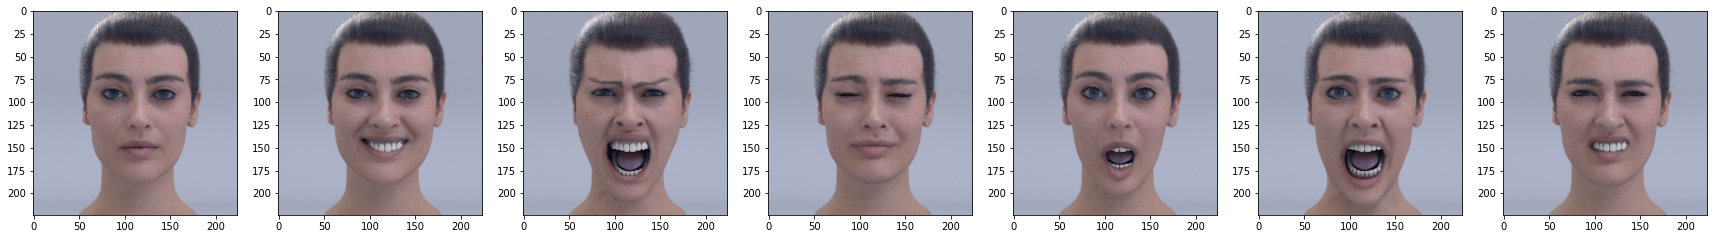

In [12]:
# plot the pre-processed images to see how the training data looks like
plt.figure(figsize=(30, 4))
for i in range(n_training):
    plt.subplot(1, n_training, i + 1)
    img = np.array(data[0][i])
    rgb_img = img[..., ::-1]
    norm_img = (rgb_img + 127.5) / 256
    plt.imshow(norm_img)

## Predict with extraction pipeline

In [15]:
# predict v4 output
preds = v4_model.predict(data[0], verbose=1)
print("[TRAIN] shape prediction", np.shape(preds))

# get feature maps that mimic a semantic selection pipeline
# keep only highest IoU semantic score
eyebrow_preds = preds[..., config['best_eyebrow_IoU_ft']]
print("shape eyebrow semantic feature selection", np.shape(eyebrow_preds))
lips_preds = preds[..., config['best_lips_IoU_ft']]
print("shape lips semantic feature selection", np.shape(lips_preds))
preds = np.concatenate((eyebrow_preds, lips_preds), axis=3)
print("[TRAIN] shape preds", np.shape(preds))

7/7 [==============================] - 1s 166ms/sample
[TRAIN] shape prediction (7, 56, 56, 256)
shape eyebrow semantic feature selection (7, 56, 56, 2)
shape lips semantic feature selection (7, 56, 56, 16)
[TRAIN] shape preds (7, 56, 56, 18)


# train and detect facial identity (Facial Recognition)

In [21]:
# create templates
config['rbf_sigma'] = config['louise_rbf_RF_sigma']
rbf_template = np.array(config['louise_rbf_RF_pos'])
fr_pattern = PatternFeatureSelection(config, template=rbf_template)

print("[RBF FR] Shape rbf_templates", np.shape(rbf_template))

[RBF FR] Shape rbf_templates (3, 2, 2)
[RBF FR] Shape rbf pattern ()
